# Scraping Hashtags on Instagram

This notebook aids in saving metadata from scraped public images from Instagram, which are using a specified hashtag. The resulting .csv file can either be used to vizualize or further analyze the content using any of the preferred plotting or natural language processing libraries. 

A python file (helper_functions.py) containing functions was created to declutter the notebook and give it some breathing room. Furthermore, a requirements.txt file contains a list of libraries which are required for the notebook to run. Usually, only the following libraries would be missing from a normal jupyter notebook installation:
- emoji (which translates emojies to a text string)
- instalooter (which does the actual scraping)
- langid (which helps in determining the language used in a caption of an image)

In the first code cell, we are importing the the pre-written functions, making sure that our later plots and vizualizations will be shown within the notebook, and surpressing warnings that may arise later due to missing language files.

Also, we are determining the hashtag, which will be scraped in the next step. This cell will also have to be executed, when loading an already scraped csv file, which will have the name of the hashtag.

In [1]:
#Loading the dependencies

from helper_functions import *

%matplotlib inline
warnings.filterwarnings('ignore')

HASHTAG = 'tuberlinarchitecture'
FILENAME="{}.csv".format(HASHTAG)

The following code cell contains the actual scraping process, which tends to take a couple of minutes to finish. It can be exited at any time by interrupting the kernel. The scraped images will still be saved to the csv file but the list will not be complete.

While running the scraper, a counter will increase its printed value to indicate how many images and rows have been added to the csv file. The counter is unlikely to reach the same number of posts as reported on the printed out link to the hashtag results search, as 

    Instagram reports more hashtagged medias than actually reachable 
    (some of them may be private, but they are still counted)
    
Source: https://github.com/althonos/InstaLooter/issues/277

If a file already exists, which has the same name as the hashtag, you will be asked whether you want to overwrite that file.

In [2]:
# create a new csv to safe the information to
overwrite_file(HASHTAG)
print("\n\n\tLink to IG Hashtag page:\n\thttps://www.instagram.com/explore/tags/{}/\n\n\n".format(HASHTAG))

tuberlinarchitecture.csv does not exist.
	tuberlinarchitecture.csv created.


	Link to IG Hashtag page:
	https://www.instagram.com/explore/tags/tuberlinarchitecture/





In [3]:
# let this run for bit...
looter = HashtagLooter(HASHTAG)

counter = 0
for media in looter.medias():
    post_info(HASHTAG,media)
    counter +=1
    print(counter,end='\r')

Reading the created csv file back to the notebook, while disregarding any errors or duplicate entries, as well as creating additional columns to have a human readable date, timestamp, and the hashtags and the number of hashtags used per caption.

If desired, captions may be filtered out by the detected language. This is currently commented out but functions as intended.

Finishing this process prints out the length of the dataframe before and after the cleanup process, and some values related to the dataframe.

In [4]:
## read data from file, disregard errors, and drop duplicates
df = pd.read_csv(FILENAME,error_bad_lines=False,index_col=None,sep='; ').drop_duplicates()

print('dataframe length:\t\t{}'.format(len(df)))

# add hashtags as seperate cols
df['num_of_hashtags'], df['hashtags'] = zip(*df['edge_media_to_caption'].map(hashtags_in_str))

# add detected language as col
#df['detected_language'] = df.apply(lambda row: language_id(row.edge_media_to_caption), axis = 1) 

# convert UNIX timestamp to datetime-timestamp
df['timestamp'] = pd.to_datetime(df['taken_at_timestamp'], unit='s')

#just the date
df['just_date'] = df['timestamp'].dt.date

# remove rows where there are no hashtags
df = df[df.num_of_hashtags != 0]

# remove rows which are not "german"
#df = df[df.detected_language == 'de']

# remove rows which are not "english"
#df = df[df.detected_language == 'en']


# remove id duplicates
df = df.drop_duplicates(subset='id',keep='first')

#remove empty
df = df.drop_duplicates().dropna()


# add empty cols to populate later
#df['caption_is_edited'] = None
#df['location_country_code'] = None
#df['location_city_name'] = None

#convert str to int
df['edge_liked_by'] = df['edge_liked_by'].astype(np.int)
df.edge_media_to_comment = df.edge_media_to_comment.astype(np.int)
df.id = df.id.astype(np.int)
df.id = df.id.astype(np.int)
df.edge_liked_by = df.edge_liked_by.astype(np.int)
df.owner = df.owner.astype(np.int)

print('length after cleanup:\t\t{}'.format(len(df)))


display(df[['edge_media_to_comment','num_of_hashtags','edge_liked_by']].describe())
print('Average number of hashtags used per caption: {}'.format(round(df['num_of_hashtags'].mean(),2)))


dataframe length:		353
length after cleanup:		344


,edge_media_to_comment,num_of_hashtags,edge_liked_by
count,344.000000,344.000000,344.000000
mean,1.325581,14.281977,48.162791
std,2.969983,9.977182,76.061485
min,0.000000,1.000000,2.000000
25%,0.000000,6.000000,17.000000
50%,0.000000,10.000000,27.500000
75%,2.000000,28.000000,50.000000
max,30.000000,37.000000,867.000000


Average number of hashtags used per caption: 14.28


To get a general look at the number of hashtags per caption mentioning the scraped hashtag, the following scatterplot does just that. The cuttoff_date variable is a datetime.date and can be set to get a better view of a specific time frame that reaches to the latest available post, mentioning the hashtag.

The variables of the x and y axis can be changed to any of the column names from the created dataframe.
The scale of the y-axis can be set to 'linear' or 'symlog'.

Hashtag: #tuberlinarchitecture


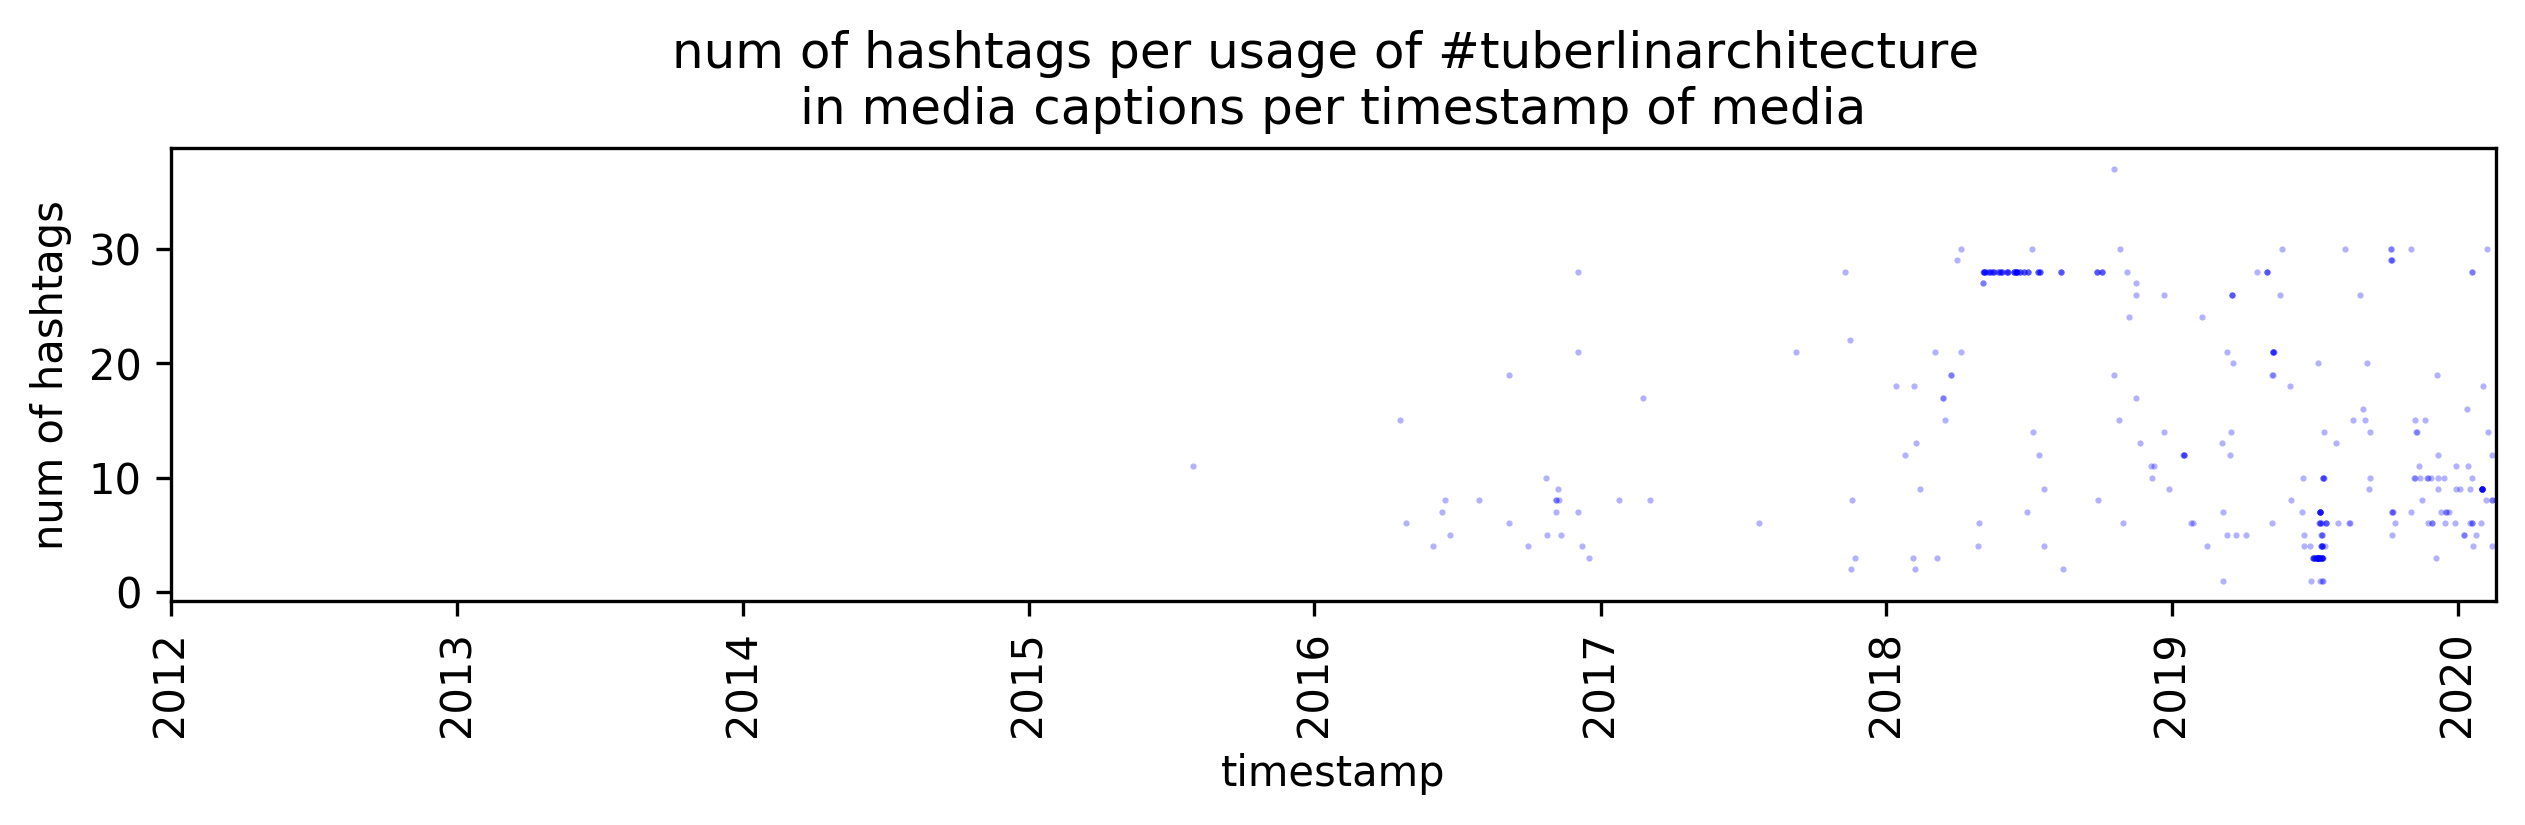

In [5]:
# Axes
y_axis='num_of_hashtags'
x_axis='timestamp' #just_date, timestamp
cuttoff_date=datetime.date(2012, 1, 1)
yscale='linear' # yscale values : 'linear' or 'symlog' for best results

draw(df,HASHTAG,y_axis,x_axis,yscale=yscale,cuttoff_date=cuttoff_date)

# includes edited captions

Hashtag: #tuberlinarchitecture


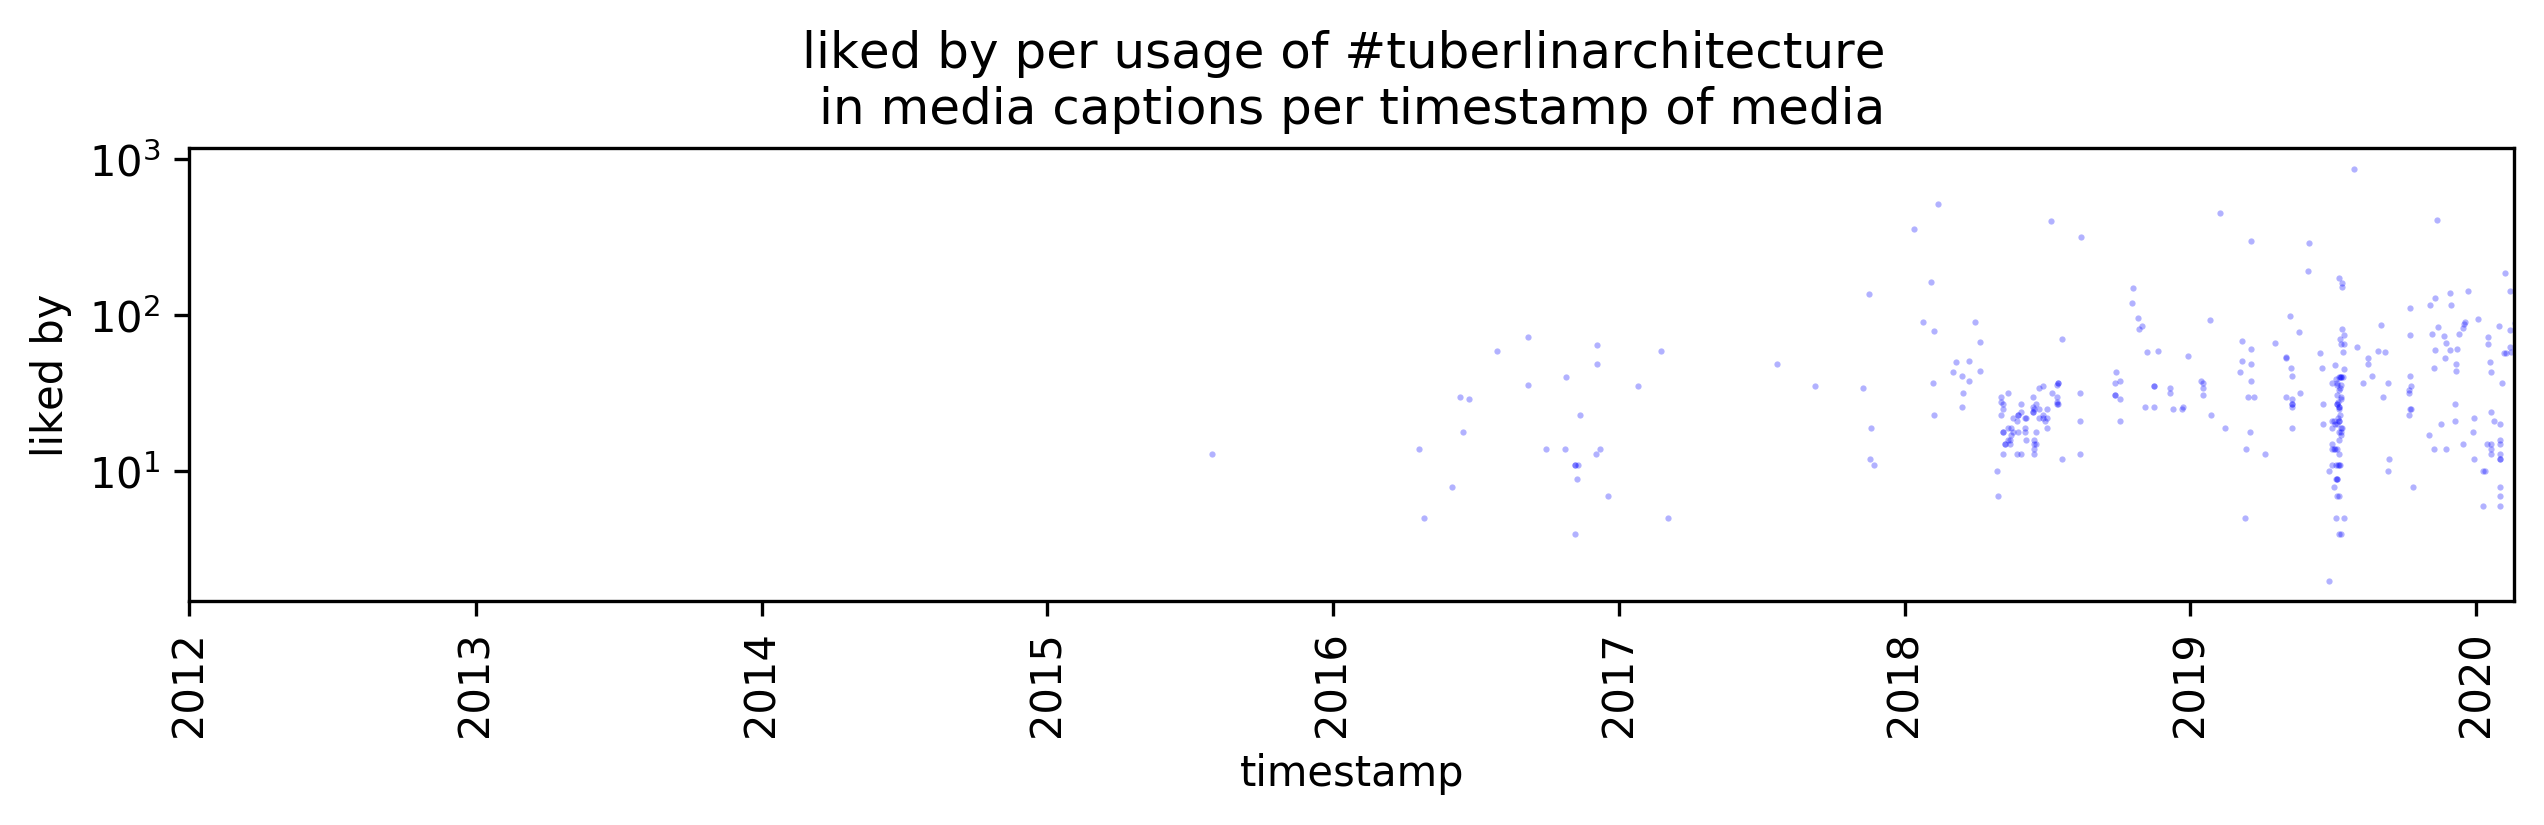

In [6]:
# Axes
y_axis='edge_liked_by'
x_axis='timestamp'
yscale='symlog'
#cuttoff_date=datetime.date(2020, 2, 9)

draw(df,HASHTAG,y_axis,x_axis,yscale=yscale,cuttoff_date=cuttoff_date)

# includes edited captions

In order to vizualize the occurences of other hashtags with the scraped hashtag, the following method is being used to generate a bar chart and a list containing the absolute and relative numbers which can help in understanding the topical realm of the hashtag, as well as 'nearest neighbors'.

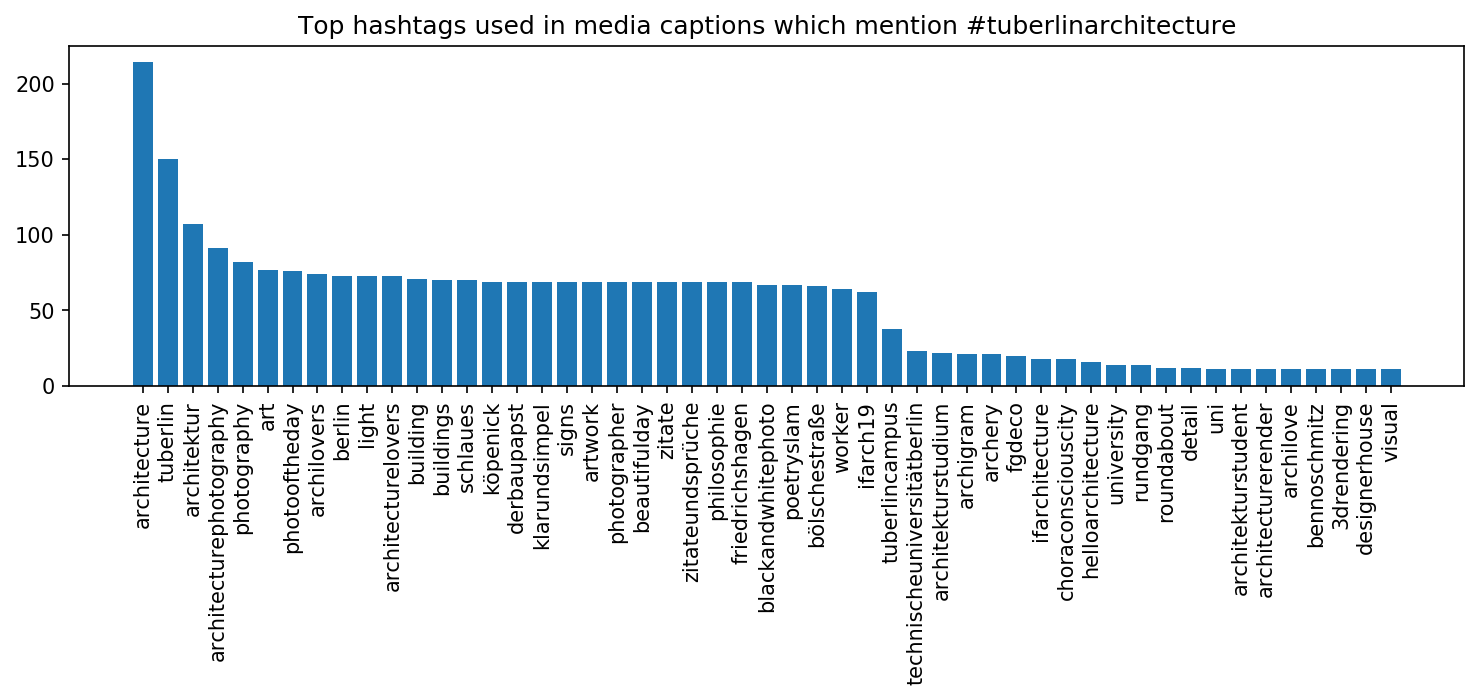

The hashtag #tuberlinarchitecture was mentioned with the hashtag #architecture
in 62.21% off all captions that featured #tuberlinarchitecture.


,hashtag,mentions,percent
0,architecture,214,0.6221
1,tuberlin,150,0.4360
2,architektur,107,0.3110
3,architecturephotography,91,0.2645
4,photography,82,0.2384
5,art,77,0.2238
6,photooftheday,76,0.2209
7,archilovers,74,0.2151
8,berlin,73,0.2122
9,light,73,0.2122


In [7]:
tag_dict ={}

for hashtags in df['hashtags']:
    for tags in [hashtags]:
        for tag in tags.split(', '):
            tag= tag.lower()
            if tag in tag_dict.keys():
                tag_dict[tag] += 1
            else:
                tag_dict[tag] = 1


# cut off limit for mentions for hashtags
occurences = round(len(df)/35)

# empty list of the hashtags to delete from the dictionary
small_num_hashtags =[]


for key in tag_dict.keys():
    if tag_dict[key] <=occurences:
        small_num_hashtags.append(key)

#delete hashtags that did not make the cut as defined by the occurences variable 
for useless_hashtag in small_num_hashtags:
    try:
        tag_dict.pop(useless_hashtag,None)
    except KeyError:
        pass
    
    
    
    
# delete the hashtag used for searching from the dict
tag_dict.pop(HASHTAG,None)

D = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1],reverse=True)}

plt.figure(num=None, figsize=(12, 3), dpi=150, facecolor='w', edgecolor='k')

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation=90)
plt.title('Top hashtags used in media captions which mention #{}'.format(HASHTAG))
plt.show()

hashtag_df = pd.DataFrame(list(D.items()),columns = ['hashtag','mentions'])
hashtag_df['percent'] = round(hashtag_df['mentions']/int(len(df['num_of_hashtags'])),4)

# read the dataframe results as: 
print("The hashtag #{} was mentioned with the hashtag #{}\nin {}% off all captions that featured #{}.".format(HASHTAG,hashtag_df['hashtag'][0],round(100*(hashtag_df['percent'][0]),2),HASHTAG))

#Top usage List
display(hashtag_df[:10])

To show hashtag usage per day, execute the following code cell, after adjusting the date of the cuttoff_date variable.

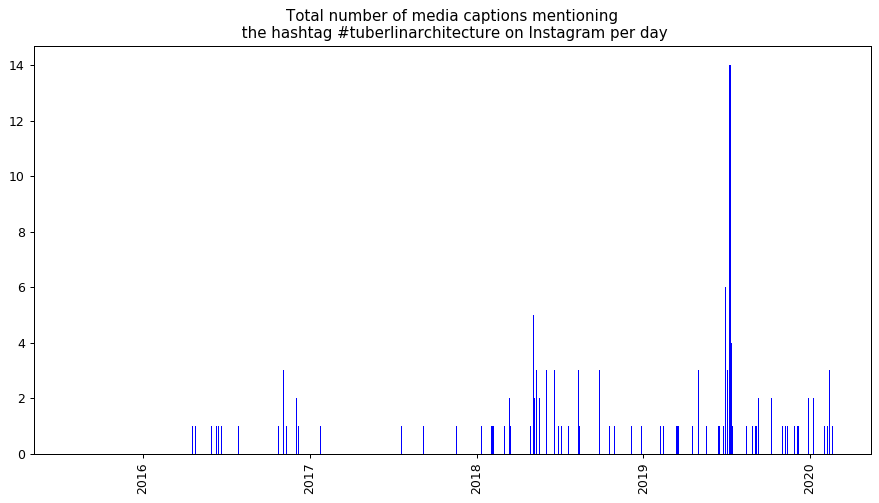

In [8]:

#min_date = df['timestamp'].min().to_pydatetime().date()
#cuttoff_date = min_date

# alternative cut
cuttoff_date = datetime.date(2012, 1, 1)

day_dict ={}

for day in df['just_date']:
    if day in day_dict.keys():
        day_dict[day] += 1
    else:
        day_dict[day] = 1
                
DAYS = {k: v for k, v in sorted(day_dict.items(), key=lambda item: item[1],reverse=True)}

for date in list(DAYS):
    if date < cuttoff_date:
        DAYS.pop(date,None)

plt.figure(num=None, figsize=(12, 6), dpi=90, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
plt.bar(DAYS.keys(), DAYS.values(),  color='b')
plt.title('Total number of media captions mentioning\n the hashtag #{} on Instagram per day'.format(HASHTAG))
plt.show()

# includes edited captions

Get the top posts sorted by number of likes, comments or time and date that the post was created by changing the sortby, and cuttoff_date variable. The values from the shortcode column can be inserted to the following string to get a direct link to the posting on Instagram.

    "https://www.instagram.com/p/{}/".format(shortcode)

In [9]:
sortby='edge_liked_by' 
# timestamp edge_liked_by num_of_hashtags edge_media_to_comment

ascending=False # True or False

# datetime limits
cuttoff_date = datetime.datetime(2012, 1, 1, 0, 0, 0)
end_date = df['timestamp'].max().to_pydatetime()

# mask
mask = (df['timestamp'] > cuttoff_date) & (df['timestamp'] <= end_date)

# assignment
cut_df = df.loc[mask]

# Top 
TOP_LIMIT = 10

#alt_df = alt_df.style.set_properties(**{'word-wrap': 'break-word'})
alt_df = df.loc[mask].sort_values(by=sortby,ascending=ascending)

df_min = (alt_df.head(TOP_LIMIT)[['timestamp','shortcode',sortby,'edge_media_to_comment','edge_liked_by','owner']])

display(df_min)

,timestamp,shortcode,edge_liked_by,edge_media_to_comment,edge_liked_by,owner
87,2019-07-29 11:07:53,B0f5h1tiJPd,867,8,867,4596290863
312,2018-02-12 09:15:41,BfF1yijhmLv,517,4,517,2043403438
197,2019-02-08 07:04:57,BtnJy2gluUv,451,4,451,5673045754
57,2019-11-12 15:49:05,B4xVfWZCiNj,405,1,405,2043403438
243,2018-07-06 14:04:39,Bk5JU_iBzf_,403,1,403,1059755
318,2018-01-12 19:37:25,Bd3ITJullRK,357,26,357,1800077846
229,2018-08-14 07:04:44,Bmc0RkLBM9_,316,6,316,2043403438
183,2019-03-19 18:47:10,BvM1KKSDfcH,297,8,297,8740596023
165,2019-06-01 20:50:01,ByLmCuIhGaO,289,17,289,3700196155
166,2019-05-31 07:46:03,ByHnh58ljAr,192,10,192,4147624125


Testing:

The following cells are still being worked on or do not work in a reliable manner.
The underlying function adds additional information per post. These include whether or not a caption was edited after initially posting the media file, the country code, and city. 

if the dataframe is to long, replace 'df' with 'df[5]' to get an idea of how it could function.

In [10]:

df_min['caption_is_edited'],df_min['country_code'],df_min['city_name']= zip(*df_min['shortcode'].map(post_location_data))

# apply additional columns to all rows
#df['caption_is_edited'],df['country_code'],df['city_name']= zip(*df['shortcode'].map(post_location_data))

# ^ issues with "too many open files" OR issue with number of requests, thus
# not reliable and only used as proof of concept in the following example

# display the dataframe
display(df_min)

,timestamp,shortcode,edge_liked_by,edge_media_to_comment,edge_liked_by,owner,caption_is_edited,country_code,city_name
87,2019-07-29 11:07:53,B0f5h1tiJPd,867,8,867,4596290863,0.0,DE,"Berlin, Germany"
312,2018-02-12 09:15:41,BfF1yijhmLv,517,4,517,2043403438,NaN,NaN,NaN
197,2019-02-08 07:04:57,BtnJy2gluUv,451,4,451,5673045754,0.0,DE,"Berlin, Germany"
57,2019-11-12 15:49:05,B4xVfWZCiNj,405,1,405,2043403438,1.0,DE,"Berlin, Germany"
243,2018-07-06 14:04:39,Bk5JU_iBzf_,403,1,403,1059755,1.0,DE,"Berlin, Germany"
318,2018-01-12 19:37:25,Bd3ITJullRK,357,26,357,1800077846,NaN,NaN,NaN
229,2018-08-14 07:04:44,Bmc0RkLBM9_,316,6,316,2043403438,NaN,NaN,NaN
183,2019-03-19 18:47:10,BvM1KKSDfcH,297,8,297,8740596023,1.0,DE,"Berlin, Germany"
165,2019-06-01 20:50:01,ByLmCuIhGaO,289,17,289,3700196155,NaN,NaN,NaN
166,2019-05-31 07:46:03,ByHnh58ljAr,192,10,192,4147624125,1.0,GB,"London, United Kingdom"


In [11]:
# tagged locations by country code
display(df_min.country_code.value_counts())

DE    5
GB    1
Name: country_code, dtype: int64

In [12]:
# tagged locations by city name
display(df_min.city_name.value_counts())

Berlin, Germany           5
London, United Kingdom    1
Name: city_name, dtype: int64

In [13]:
# get owner id from account with most uses of scraped hashtag
owner_id = df.owner.value_counts().index[0]


# get first shortcode from owner with the most images
owner_id_shortcode = df[df.owner == owner_id]['shortcode'].iloc[0]

# get username of the ownerid
print("https://instagram.com/{}/".format(get_username(owner_id_shortcode)))

https://instagram.com/der_baupapst/


In [14]:
# top 3 accounts with the most mentions of the scraped hashtag
df.owner.value_counts()[:3]

7641548682     69
3509647912     47
11765024201    23
Name: owner, dtype: int64